# Run k=5 anf k=6 analysis to see whether thhere are any missing similarities betweeen peptides in PAA inventory file

In [1]:
pwd

'/Users/mariaalonso/Work/protease_activity_analysis/notebooks'

In [2]:
cd ..

/Users/mariaalonso/Work/protease_activity_analysis


In [3]:
#Import packages
import pandas as pd
import scipy as sp
from scipy import stats
from sklearn.cluster import AgglomerativeClustering
import numpy as np
from scipy.stats import zscore
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import scipy.stats as ss
import csv
import pickle
import protease_activity_analysis as paa


In [4]:
# Import excel file containing all natural sequences from the lab with a single name
path_seq = 'data/screens/PAA/Peptide_Inventory_150.xlsx'

# Make dataframe with all peptides
data = pd.read_excel(path_seq, header=0, index_col=0)

data

,LUAD panel,Q/PQ/SQ/PX panel,LCS panel,BV panel,TQ panel,Sequence,Composition
PAA,,,,,,,
S1,NaN,NaN,LQ1,NaN,NaN,GRQRRVVGG,Natural
S2,NaN,NaN,LQ2,NaN,NaN,GRQARAVGG,Natural
S3,NaN,NaN,LQ3,NaN,NaN,GRRARVVGG,Natural
S4,PP04,Q6,LQ4,NaN,TQ6,GPLGLRSWG,Natural
S5,NaN,NaN,LQ5,NaN,NaN,GWEAVRSAMWG,Natural
...,...,...,...,...,...,...,...
S146,NaN,NaN,NaN,BV13,NaN,GGPRAAA[Phe(homo)]TSPG,Non-natural
S147,NaN,NaN,NaN,BV14,NaN,GGTGPPGYTG,Natural
S148,NaN,NaN,NaN,BV15,NaN,GGTGLPVYQG,Natural


In [5]:
# Filter for natural amino acids only
data_nat = data[data['Composition']=='Natural']
data_nat

,LUAD panel,Q/PQ/SQ/PX panel,LCS panel,BV panel,TQ panel,Sequence,Composition
PAA,,,,,,,
S1,NaN,NaN,LQ1,NaN,NaN,GRQRRVVGG,Natural
S2,NaN,NaN,LQ2,NaN,NaN,GRQARAVGG,Natural
S3,NaN,NaN,LQ3,NaN,NaN,GRRARVVGG,Natural
S4,PP04,Q6,LQ4,NaN,TQ6,GPLGLRSWG,Natural
S5,NaN,NaN,LQ5,NaN,NaN,GWEAVRSAMWG,Natural
...,...,...,...,...,...,...,...
S144,NaN,NaN,NaN,BV11,NaN,GGNLARALKQTIG,Natural
S145,NaN,NaN,NaN,BV12,NaN,GGHMVQHLIQWHG,Natural
S147,NaN,NaN,NaN,BV14,NaN,GGTGPPGYTG,Natural


In [6]:
# Correct for spaces in sequence
seq_or = list(data_nat['Sequence'])
seq_new = [item.replace(' ', '') for item in seq_or]
data_nat['Sequence'] = seq_new
display(data_nat)


/Users/mariaalonso/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,LUAD panel,Q/PQ/SQ/PX panel,LCS panel,BV panel,TQ panel,Sequence,Composition
PAA,,,,,,,
S1,NaN,NaN,LQ1,NaN,NaN,GRQRRVVGG,Natural
S2,NaN,NaN,LQ2,NaN,NaN,GRQARAVGG,Natural
S3,NaN,NaN,LQ3,NaN,NaN,GRRARVVGG,Natural
S4,PP04,Q6,LQ4,NaN,TQ6,GPLGLRSWG,Natural
S5,NaN,NaN,LQ5,NaN,NaN,GWEAVRSAMWG,Natural
...,...,...,...,...,...,...,...
S144,NaN,NaN,NaN,BV11,NaN,GGNLARALKQTIG,Natural
S145,NaN,NaN,NaN,BV12,NaN,GGHMVQHLIQWHG,Natural
S147,NaN,NaN,NaN,BV14,NaN,GGTGPPGYTG,Natural


In [7]:
# Function to generate kmers of different sizes
def generate_kmers(sub_list, seq_list, k):
    """ Returns dictionary containing kmers of length k in each substrate 

        Args:
            sub_list (list, str): list of all substrates
            seq_list (list, str): list of sequences
            k (int): kmer length
        Returns:
            kmer_dict (dict): dictionary where keys are substrates and values are kmers of length k in a given substrate 
    """
    kmer_dict = {}  #create empy dictionary, keys will be the name of the peptide and the values will be the kmers
    for i in np.arange(len(sub_list)):
        temp_seq = seq_list[i]
        #print(temp_seq)
        #print(len(temp_seq))
        n=len(temp_seq)-k+1
        #print(n)
        temp_kmer = []
        for j in np.arange(n): temp_kmer.append(temp_seq[j:j+k])
        kmer_dict[sub_list[i]] = temp_kmer
        
    return kmer_dict


def find_overlapping_kmers(kmer_dict):
    """ Returns dictionary where keys are kmers and values are substrates containing each kmer
        Args:
            kmer_dict (dict): dictionary where keys are substrates and values are kmers of length k in a given substrate 
        Returns:
            overlap_dict (dict): dictionary where keys are kmers and values are substrates containg a given kmer
    """
    unique = list(sorted({ele for val in kmer_dict.values() for ele in val}))
    print('Number of unique kmers is:', len(unique))
    
    # create new dictionary that will store peptides with overlapping kmers
    overlap_dict = {}  
    overlap_keys = unique
    for i in overlap_keys:
        overlap_dict[i] = []
        
    for el in unique:
        for key in kmer_dict.keys(): 
            if el in kmer_dict[key]:
                overlap_dict[el].append(key)
    
    return overlap_dict

In [8]:
# Run generate_kmer function for all peptides in PAA for all kmer lengths of interest
subs = data_nat.index.to_list()
seqs = data_nat['Sequence'].to_list()

kmer_2=generate_kmers(subs, seqs, k=2)
kmer_3=generate_kmers(subs, seqs, k=3)
kmer_4=generate_kmers(subs, seqs, k=4)
kmer_5=generate_kmers(subs, seqs, k=5)
kmer_6=generate_kmers(subs, seqs, k=6)
kmer_7=generate_kmers(subs, seqs, k=7)
kmer_8=generate_kmers(subs, seqs, k=8)
kmer_9=generate_kmers(subs, seqs, k=9)
kmer_10=generate_kmers(subs, seqs, k=10)


In [9]:
kmer_2

{'S1': ['GR', 'RQ', 'QR', 'RR', 'RV', 'VV', 'VG', 'GG'],
 'S2': ['GR', 'RQ', 'QA', 'AR', 'RA', 'AV', 'VG', 'GG'],
 'S3': ['GR', 'RR', 'RA', 'AR', 'RV', 'VV', 'VG', 'GG'],
 'S4': ['GP', 'PL', 'LG', 'GL', 'LR', 'RS', 'SW', 'WG'],
 'S5': ['GW', 'WE', 'EA', 'AV', 'VR', 'RS', 'SA', 'AM', 'MW', 'WG'],
 'S6': ['GW', 'WI', 'IG', 'GF', 'FR', 'RN', 'NA', 'AG', 'GA', 'AG'],
 'S7': ['GP', 'PL', 'LG', 'GF', 'FR', 'RV', 'VG'],
 'S8': ['GP', 'PL', 'LG', 'GL', 'LR', 'RG'],
 'S9': ['GA', 'AT', 'TP', 'PK', 'KI', 'IF', 'FN', 'NT', 'TE', 'EG'],
 'S10': ['GE', 'ET', 'TR', 'RI', 'II', 'IK', 'KG', 'GF', 'FE', 'EG'],
 'S11': ['GP', 'PL', 'LA', 'AL', 'LW', 'WA', 'AR', 'RG'],
 'S12': ['GA', 'AL', 'LV', 'VP', 'PR', 'RG', 'GS', 'SA', 'AG'],
 'S13': ['GG', 'GL', 'LV', 'VP', 'PR', 'RG', 'GS', 'SG'],
 'S14': ['GR', 'RQ', 'QA', 'AR', 'RQ', 'QV', 'VG', 'GG'],
 'S15': ['GL', 'LQ', 'QA', 'AR', 'RV', 'VV', 'VG', 'GG'],
 'S16': ['GG', 'GG', 'GS', 'SG', 'GR', 'RS', 'SA', 'AN', 'NA', 'AK', 'KG'],
 'S17': ['GG', 'GV', 'VP', 

In [9]:
# Find overlap of kmers of different lengths between bhatia lab and revitope
kmer_list = [kmer_2, kmer_3, kmer_4, kmer_5, kmer_6, kmer_7, kmer_8, kmer_9, kmer_10]

for i in np.arange(len(kmer_list)):
    k=i+2
    print('For k=', k)
    overlap = find_overlapping_kmers(kmer_list[i])
    
    kmer_file = open('data/screens/PAA/kmer_analyses/kmer_'+str(k)+'_paa.pickle', 'wb')
    pickle.dump(overlap, kmer_file)
#     with open('data/screens/PAA/kmer_analyses/kmer_'+str(k)+'_paa.csv', 'w') as f:
#         for key in overlap.keys():
#             f.write("%s,%s\n"%(key,overlap[key]))
            

        

For k= 2
Number of unique kmers is: 280
For k= 3
Number of unique kmers is: 729
For k= 4
Number of unique kmers is: 828
For k= 5
Number of unique kmers is: 759
For k= 6
Number of unique kmers is: 660
For k= 7
Number of unique kmers is: 542
For k= 8
Number of unique kmers is: 414
For k= 9
Number of unique kmers is: 290
For k= 10
Number of unique kmers is: 170


In [10]:
# First run this to have access to all functions in paa
data_files = ['data/screens/PAA/PAA_screens/Bhatia1_PAA.csv', 'data/screens/PAA/PAA_screens/Bhatia2_PAA.csv']
sequence_file = 'data/screens/PAA/Peptide_Inventory_150.csv'
names_file = 'data/screens/PAA/names_dict.pkl'

data = paa.database.SubstrateDatabase(data_files, sequence_file, names_file)


# Implement is kmer in dataset
# kmer_q = 'PLGL'

def search_kmer(kmer_q):
    """ Returns substrates in database containing kmer of interest
        Args:
            kmer_q (str): kmer to query
    """
    kmer_len = len(kmer_q)

    f = open('data/screens/PAA/kmer_analyses/kmer_'+str(kmer_len)+'_paa.pickle', 'rb')
    kmer_dict_q = pickle.load(f)
    
    keys_q = kmer_dict_q.keys()
    
    if kmer_q in keys_q:
        subs_q = kmer_dict_q[kmer_q]
        
        seqs_q = []
        for seq in subs_q:
            seqs_q.append(data.get_sequence_of_name(seq))
        df = pd.DataFrame(index = np.arange(len(subs_q)))
        df['Peptide'] = subs_q
        df['Sequence'] = seqs_q
        
    else:
        print('K-mer not in dataset, please enter some other k-mer')
        df = None
    
    return df
    




In [11]:
search_kmer('PLGL')

,Peptide,Sequence
0,S4,GPLGLRSWG
1,S8,GPLGLRG
2,S57,GGGPLGLARG
3,S94,GGPLGLRWW


In [12]:
search_kmer('AAAA')

K-mer not in dataset, please enter some other k-mer


In [30]:
search_kmer('AA')

2
['S31', 'S37', 'S43', 'S80', 'S89', 'S102', 'S108', 'S131', 'S150']
['GAGPRKAAKG', 'GMAALIVRPDLG', 'GMAALITRPDFG', 'GGAAEAISDA', 'GGKAAATQKK', 'GGVWAAEAIS', 'GAANLTRG', 'GSGHMHAALTAG', 'GGAAFAG']


,Peptide,Sequence
0,S31,GAGPRKAAKG
1,S37,GMAALIVRPDLG
2,S43,GMAALITRPDFG
3,S80,GGAAEAISDA
4,S89,GGKAAATQKK
5,S102,GGVWAAEAIS
6,S108,GAANLTRG
7,S131,GSGHMHAALTAG
8,S150,GGAAFAG


In [13]:
def similarity(str1, str2):
    from fuzzywuzzy import fuzz
    """ Calculate similarity metrics between two strings
        Args:
            str1 (str): sequence 1 to compare
            str2 (str): sequence 2 to compare
        Returns:
            ratio (int): Levenshtein distance similarity ratio (Ratio) as a percent
            partial_ratio (int): Partial Levenshtein distance similarity ratio (Ratio) as a percent
    """
    # Calculate Levenshtein distance similarity ratio (Ratio) as well as a Partial Levenshtein distance similarity ratio that ignores differences in length
    ratio = fuzz.ratio(str1.lower(),str2.lower())
    partial_ratio = fuzz.partial_ratio(str1.lower(),str2.lower())
    
    return ratio, partial_ratio

In [14]:
def similarity_matrix(subs_list, seqs_list):
    """ Calculate pairwise similarity between all substartes in subs_list and return similarity matrix
        Args:
            subs_list (list, str): list containing all names of substrates of interest
            seqs_list (list, str): list containing their corresponding sequences
        Returns:
            sim_m (pandas df): df of all subs_list x subs_list containig pairwise Levenshtein distance similarity ratio (Ratio) 
            sim_par_m (pandas df): df of all subs_list x subs_list containig pairwise Partial Levenshtein distance similarity ratio (Ratio)
    """
    rows = subs_list
    cols = subs_list
    sim_m = pd.DataFrame(index=rows, columns=cols)
    sim_par_m = pd.DataFrame(index=rows, columns=cols)

    j=0
    for j in np.arange(len(rows)):
        for i in np.arange(len(rows)):
            Str1 = seqs_list[j]
            Str2 = seqs_list[i]
            sim_m.iloc[j,i] = similarity(Str1, Str2)[0]
            sim_par_m.iloc[j,i] = similarity(Str1, Str2)[1]
            
        j=j+1
        
    return sim_m, sim_par_m

In [15]:
# Generate similarity matrix for sequence list of interest
subs = data_nat.index.to_list()
seqs = data_nat['Sequence'].to_list()
#print(seqs)
mat, par_mat = similarity_matrix(subs, seqs)
display(mat)

,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,...,S138,S139,S140,S141,S143,S144,S145,S147,S148,S150
S1,100,78,89,33,30,40,47,38,20,40,...,33,40,30,32,48,36,27,32,32,38
S2,78,100,78,33,50,50,47,38,30,40,...,33,40,30,32,48,45,27,32,32,50
S3,89,78,100,33,40,50,47,38,30,40,...,33,40,30,32,38,36,27,32,32,38
S4,33,33,33,100,50,40,71,88,30,30,...,44,50,60,42,48,45,45,42,42,38
S5,30,50,40,50,100,45,32,33,27,36,...,20,45,36,19,26,42,33,19,29,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S144,36,45,36,45,42,50,38,50,42,33,...,36,42,50,52,40,100,38,35,43,50
S145,27,27,27,45,33,25,38,40,25,25,...,45,42,33,35,40,38,100,26,43,30
S147,32,32,32,42,19,38,44,47,48,38,...,53,38,38,50,45,35,26,100,70,35
S148,32,32,32,42,29,38,44,47,38,38,...,63,57,48,60,45,43,43,70,100,35


/Users/mariaalonso/opt/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


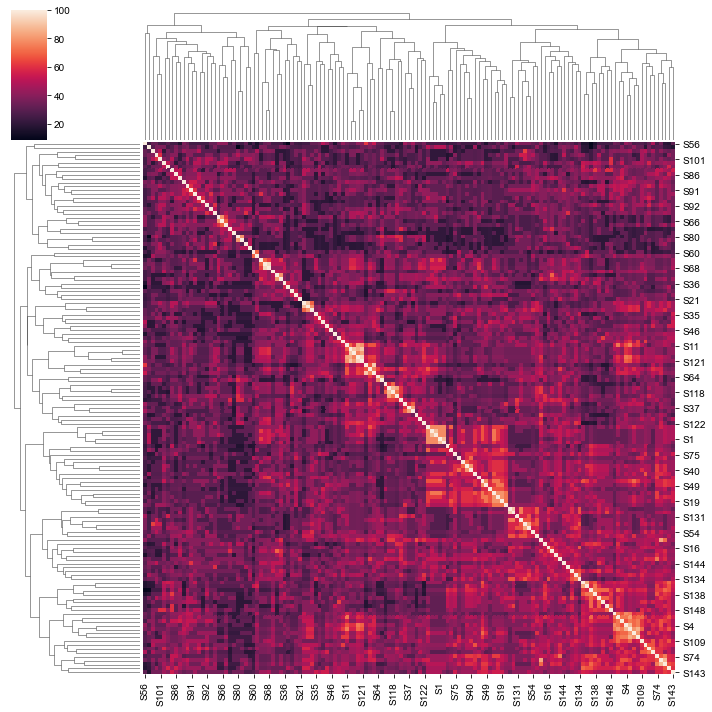

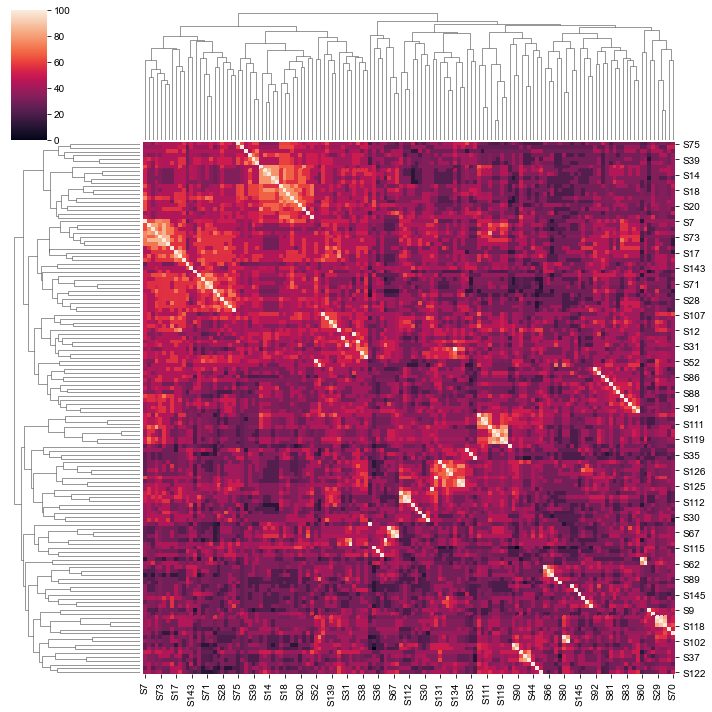

In [16]:
# Plot clustermap of similarity scores
mat = mat.astype(float)
par_mat = par_mat.astype(float)

cluster_grid_mat = sns.clustermap(mat)

cluster_grid_par_mat = sns.clustermap(par_mat)

Text(0, 0.5, 'Frequency')

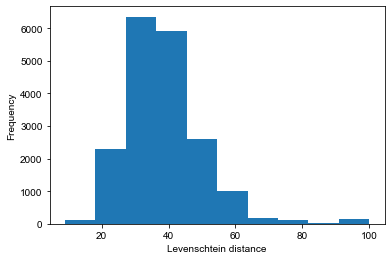

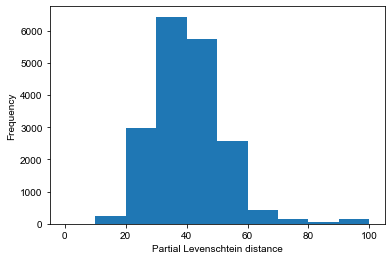

In [17]:
# Make histogram of similairyt scores
sim = np.concatenate(mat.values)
par_sim = np.concatenate(par_mat.values)

fig = plt.figure()
plt.hist(sim)
plt.xlabel('Levenschtein distance')
plt.ylabel('Frequency')


fig = plt.figure()
plt.hist(par_sim)
plt.xlabel('Partial Levenschtein distance')
plt.ylabel('Frequency')

In [18]:
# Make similarity 
num_row = len(par_mat.index)
print(len(par_mat.index))

num_col = len(par_mat.columns)
print(len(par_mat.columns))

pair_sim = pd.DataFrame(columns = ['Peptide 1', 'Sequence 1', 'Peptide 2', 'Sequence 2' ,'Similarity'], index=np.arange(num_row*num_col))

display(pair_sim)
n=0
for i in np.arange(num_row):
    for j in np.arange(num_col):
        pep1=par_mat.index[i]
        pair_sim.iloc[n,0] = pep1
        pair_sim.iloc[n,1] = data['Sequence'].loc[pep1]
        pep2=par_mat.columns[j]
        pair_sim.iloc[n,2]=pep2
        pair_sim.iloc[n,3] = data['Sequence'].loc[pep2]
        pair_sim.iloc[n,4] = par_mat.iloc[i,j]
        n=n+1

display(pair_sim)       
        
    

137
137


,Peptide 1,Sequence 1,Peptide 2,Sequence 2,Similarity
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
18764,NaN,NaN,NaN,NaN,NaN
18765,NaN,NaN,NaN,NaN,NaN
18766,NaN,NaN,NaN,NaN,NaN
18767,NaN,NaN,NaN,NaN,NaN


TypeError: 'SubstrateDatabase' object is not subscriptable

In [ ]:
# make new columns with combined name, remove duplicates and sort by similarity
pair_sim['Peptide pair']=pair_sim['Peptide 1']+'-'+pair_sim['Peptide 2']
# pair_sim2=pair_sim.drop_duplicates(subset=['Peptide pair'])
pair_sim_sorted = pair_sim.sort_values(by=['Similarity'], ascending=False)
pair_sim_sorted.to_csv('outputs/PAA/sorted_pairwise_partial_levenschtein_distance_paa_bhatia.csv')

pair_sim_sorted  

In [19]:
# Testing the colorama package
from colorama import init, Fore, Back, Style

# Initializes Colorama
#init(autoreset=True)
print('Style.NORMAL')
print(Style.NORMAL + Back.RED + Fore.BLACK + "D")
print(Style.NORMAL + Back.RED + Fore.BLACK + "E")
print(Style.NORMAL + Back.YELLOW + Fore.BLACK + "C")
print(Style.NORMAL + Back.YELLOW + Fore.BLACK + "M")
print(Style.NORMAL + Back.BLUE + Fore.WHITE + "K")
print(Style.NORMAL + Back.BLUE + Fore.WHITE + "R")
print(Style.NORMAL + Back.LIGHTYELLOW_EX + Fore.BLACK + "S")
print(Style.NORMAL + Back.LIGHTYELLOW_EX + Fore.BLACK + "T")
print(Style.NORMAL + Back.LIGHTBLUE_EX + Fore.WHITE + "F")
print(Style.NORMAL + Back.LIGHTBLUE_EX + Fore.WHITE + "Y")
print(Style.NORMAL + Back.CYAN + Fore.BLACK + "N")
print(Style.NORMAL + Back.CYAN + Fore.BLACK + "Q")
print(Style.NORMAL + Back.WHITE + Fore.BLACK + "G")
print(Style.NORMAL + Back.GREEN + Fore.BLACK + "L")
print(Style.NORMAL + Back.GREEN + Fore.BLACK + "V")
print(Style.NORMAL + Back.LIGHTBLACK_EX + Fore.WHITE + "A")
print(Style.NORMAL + Back.LIGHTMAGENTA_EX + Fore.BLACK + "W")
print(Style.NORMAL + Back.LIGHTCYAN_EX + Fore.WHITE + "H")
print(Style.NORMAL + Back.MAGENTA + Fore.WHITE + "P")

print('Style.BTIGHT')
print(Style.BRIGHT + Back.RED + Fore.BLACK + "D")
print(Style.BRIGHT + Back.RED + Fore.BLACK + "E")
print(Style.BRIGHT + Back.YELLOW + Fore.BLACK + "C")
print(Style.BRIGHT + Back.YELLOW + Fore.BLACK + "M")
print(Style.BRIGHT + Back.BLUE + Fore.WHITE + "K")
print(Style.BRIGHT + Back.BLUE + Fore.WHITE + "R")
print(Style.BRIGHT + Back.LIGHTYELLOW_EX + Fore.BLACK + "S")
print(Style.BRIGHT + Back.LIGHTYELLOW_EX + Fore.BLACK + "T")
print(Style.BRIGHT + Back.LIGHTBLUE_EX + Fore.WHITE + "F")
print(Style.BRIGHT + Back.LIGHTBLUE_EX + Fore.WHITE + "Y")
print(Style.BRIGHT + Back.CYAN + Fore.BLACK + "N")
print(Style.BRIGHT + Back.CYAN + Fore.BLACK + "Q")
print(Style.BRIGHT + Back.WHITE + Fore.BLACK + "G")
print(Style.BRIGHT + Back.GREEN + Fore.BLACK + "L")
print(Style.BRIGHT + Back.GREEN + Fore.BLACK + "V")
print(Style.BRIGHT + Back.LIGHTBLACK_EX + Fore.WHITE + "A")
print(Style.BRIGHT + Back.LIGHTMAGENTA_EX + Fore.BLACK + "W")
print(Style.BRIGHT + Back.LIGHTCYAN_EX + Fore.WHITE + "H")
print(Style.BRIGHT + Back.MAGENTA + Fore.WHITE + "P")



Style.NORMAL
D
E
C
M
K
R
S
T
F
Y
N
Q
G
L
V
A
W
H
P
Style.BTIGHT
D
E
C
M
K
R
S
T
F
Y
N
Q
G
L
V
A
W
H
P


In [20]:
aa_dict =  {'D' : Style.NORMAL + Back.RED + Fore.BLACK + "D",
            'd' : Style.NORMAL + Back.RED + Fore.BLACK + "d",
            'E' : Style.NORMAL + Back.RED + Fore.BLACK + "E",
            'e' : Style.NORMAL + Back.RED + Fore.BLACK + "e",
            'C' : Style.NORMAL + Back.YELLOW + Fore.BLACK + "C",
            'c' : Style.NORMAL + Back.YELLOW + Fore.BLACK + "c",
            'M' : Style.NORMAL + Back.YELLOW + Fore.BLACK + "M",
            'm' : Style.NORMAL + Back.YELLOW + Fore.BLACK + "m",
            'K' : Style.NORMAL + Back.BLUE + Fore.WHITE + "K",
            'k' : Style.NORMAL + Back.BLUE + Fore.WHITE + "k",
            'R' : Style.NORMAL + Back.BLUE + Fore.WHITE + "R",
            'r' : Style.NORMAL + Back.BLUE + Fore.WHITE + "r",
            'S' : Style.NORMAL + Back.LIGHTYELLOW_EX + Fore.BLACK + "S",
            's' : Style.NORMAL + Back.LIGHTYELLOW_EX + Fore.BLACK + "s",
            'T' : Style.NORMAL + Back.LIGHTYELLOW_EX + Fore.BLACK + "T",
            't' : Style.NORMAL + Back.LIGHTYELLOW_EX + Fore.BLACK + "t",
            'F' : Style.NORMAL + Back.LIGHTBLUE_EX + Fore.WHITE + "F",
            'f' : Style.NORMAL + Back.LIGHTBLUE_EX + Fore.WHITE + "f",
            'Y' : Style.NORMAL + Back.LIGHTBLUE_EX + Fore.WHITE + "Y",
            'y' : Style.NORMAL + Back.LIGHTBLUE_EX + Fore.WHITE + "y",
            'N' : Style.NORMAL + Back.CYAN + Fore.BLACK + "N",
            'n' : Style.NORMAL + Back.CYAN + Fore.BLACK + "n",
            'Q' : Style.NORMAL + Back.CYAN + Fore.BLACK + "Q",
            'q' : Style.NORMAL + Back.CYAN + Fore.BLACK + "q",
            'G' : Style.NORMAL + Back.WHITE + Fore.BLACK + "G",
            'g' : Style.NORMAL + Back.WHITE + Fore.BLACK + "g",
            'L' : Style.NORMAL + Back.GREEN + Fore.BLACK + "L",
            'l' : Style.NORMAL + Back.GREEN + Fore.BLACK + "l",
            'V' : Style.NORMAL + Back.GREEN + Fore.BLACK + "V",
            'v' : Style.NORMAL + Back.GREEN + Fore.BLACK + "v",
            'I' : Style.NORMAL + Back.GREEN + Fore.BLACK + "I",
            'i' : Style.NORMAL + Back.GREEN + Fore.BLACK + "i",
            'A' : Style.NORMAL + Back.LIGHTBLACK_EX + Fore.WHITE + "A",
            'a' : Style.NORMAL + Back.LIGHTBLACK_EX + Fore.WHITE + "a",
            'W' : Style.NORMAL + Back.LIGHTMAGENTA_EX + Fore.BLACK + "W",
            'w' : Style.NORMAL + Back.LIGHTMAGENTA_EX + Fore.BLACK + "w",
            'H' : Style.NORMAL + Back.LIGHTCYAN_EX + Fore.WHITE + "H",
            'h' : Style.NORMAL + Back.LIGHTCYAN_EX + Fore.WHITE + "h",
            'P' : Style.NORMAL + Back.MAGENTA + Fore.WHITE + "P",
            'p' : Style.NORMAL + Back.MAGENTA + Fore.WHITE + "p"
           }


In [21]:
def color_seq(ex_sub):
    len_ex_sub = len(ex_sub)
    # print(len_ex_sub)
    
    if len_ex_sub == 7:
        color_sub = aa_dict[ex_sub[0]]+aa_dict[ex_sub[1]]+aa_dict[ex_sub[2]]+aa_dict[ex_sub[3]]+aa_dict[ex_sub[4]]+aa_dict[ex_sub[5]]+aa_dict[ex_sub[6]]
        #print(aa_dict[ex_sub[0]]+aa_dict[ex_sub[1]]+aa_dict[ex_sub[2]]+aa_dict[ex_sub[3]]+aa_dict[ex_sub[4]]+aa_dict[ex_sub[5]]+aa_dict[ex_sub[6]])
    elif len_ex_sub == 8:
        color_sub = aa_dict[ex_sub[0]]+aa_dict[ex_sub[1]]+aa_dict[ex_sub[2]]+aa_dict[ex_sub[3]]+aa_dict[ex_sub[4]]+aa_dict[ex_sub[5]]+aa_dict[ex_sub[6]]+aa_dict[ex_sub[7]]
    elif len_ex_sub == 9:
        color_sub = aa_dict[ex_sub[0]]+aa_dict[ex_sub[1]]+aa_dict[ex_sub[2]]+aa_dict[ex_sub[3]]+aa_dict[ex_sub[4]]+aa_dict[ex_sub[5]]+aa_dict[ex_sub[6]]+aa_dict[ex_sub[7]]+aa_dict[ex_sub[8]]
    elif len_ex_sub == 10:
        color_sub = aa_dict[ex_sub[0]]+aa_dict[ex_sub[1]]+aa_dict[ex_sub[2]]+aa_dict[ex_sub[3]]+aa_dict[ex_sub[4]]+aa_dict[ex_sub[5]]+aa_dict[ex_sub[6]]+aa_dict[ex_sub[7]]+aa_dict[ex_sub[8]]+aa_dict[ex_sub[9]]
    elif len_ex_sub == 11:    
        color_sub = aa_dict[ex_sub[0]]+aa_dict[ex_sub[1]]+aa_dict[ex_sub[2]]+aa_dict[ex_sub[3]]+aa_dict[ex_sub[4]]+aa_dict[ex_sub[5]]+aa_dict[ex_sub[6]]+aa_dict[ex_sub[7]]+aa_dict[ex_sub[8]]+aa_dict[ex_sub[9]]+aa_dict[ex_sub[10]]
    elif len_ex_sub == 12:    
        color_sub = aa_dict[ex_sub[0]]+aa_dict[ex_sub[1]]+aa_dict[ex_sub[2]]+aa_dict[ex_sub[3]]+aa_dict[ex_sub[4]]+aa_dict[ex_sub[5]]+aa_dict[ex_sub[6]]+aa_dict[ex_sub[7]]+aa_dict[ex_sub[8]]+aa_dict[ex_sub[9]]+aa_dict[ex_sub[10]]+aa_dict[ex_sub[11]]
    elif len_ex_sub == 13:    
        color_sub = aa_dict[ex_sub[0]]+aa_dict[ex_sub[1]]+aa_dict[ex_sub[2]]+aa_dict[ex_sub[3]]+aa_dict[ex_sub[4]]+aa_dict[ex_sub[5]]+aa_dict[ex_sub[6]]+aa_dict[ex_sub[7]]+aa_dict[ex_sub[8]]+aa_dict[ex_sub[9]]+aa_dict[ex_sub[10]]+aa_dict[ex_sub[11]]+aa_dict[ex_sub[12]]
    elif len_ex_sub == 14:
        color_sub = aa_dict[ex_sub[0]]+aa_dict[ex_sub[1]]+aa_dict[ex_sub[2]]+aa_dict[ex_sub[3]]+aa_dict[ex_sub[4]]+aa_dict[ex_sub[5]]+aa_dict[ex_sub[6]]+aa_dict[ex_sub[7]]+aa_dict[ex_sub[8]]+aa_dict[ex_sub[9]]+aa_dict[ex_sub[10]]+aa_dict[ex_sub[11]]+aa_dict[ex_sub[12]]+aa_dict[ex_sub[13]]
    else: 
        print('Substrate length out of range')
        print(Style.RESET_ALL)
        print(ex_sub)
        color_sub = ex_sub
    
    return color_sub


In [23]:
# Try for all AAs
for i in np.arange(data_nat.shape[0]):
    # print(i)
    sub = data_nat.iloc[i]['Sequence']
    #print(sub)
    color_sub = color_seq(sub)
    print(color_sub)

GRQRRVVGG
GRQARAVGG
GRRARVVGG
GPLGLRSWG
GWEAVRSAMWG
GWIGFRNAGAG
GPLGFRVG
GPLGLRG
GATPKIFNTEG
GETRIIKGFEG
GPLALWARG
GALVPRGSAG
GGLVPRGSG
GRQARQVGG
GLQARVVGG
GGGSGRSANAKG
GGVPRGG
GRQSRIVGGG
GILSRIVGGG
GGRKRKVGGSG
GDEKGKARDFFG
GKPISLISSG
GLAQAFRSG
GRPLALWESQG
GRQRRALEKG
GIQQRSLGGG
GLRGGKGGPPPPG
GGGAPFEMSA
GPRPFNYLG
GAGPRKAAKG
GAKIRKAKKG
GAKIRGQAKG
GNSGRAVTYG
GTYSRSRYLG
GRPKPQQFWG
GMAALIVRPDLG
GGRIFLRTAG
GSGDRMWggG
GSGERMMGgG
GsDDRRAGgG
GKLRVVGGHPG
GMAALITRPDFG
GELIQRNLSPAG
GSNLTRIVGGQG
GYQIKPLKSTDG
GNIPMGLLYNKG
GPQGRIVGG
GIKPRIVGG
GPMKRLTLG
GGLGPKGQTG
GGAGGAQMGA
GGATDVTTTP
GGLSLPETGE
GSPLAQAVRSSS
GSSMAQTLTLRSSS
GGGPLGLARG
GMERMGG
GGGGPGG
GEWWMDYQG
GFLRRQFKVVT
GVGRPEWWMDG
GLGALLRVKRLE
GLASASTMDG
GGKGRGLSLG
GHGDQMAQKS
GRAEQQRLKG
GRAEQQRLG
GDQMAQKSQG
GAIEFDSG
GGPQGIWGQ
GGPVPLSLVM
GGPLGVRGK
GGfPRSGGG
GSGSKIIGGG
GPLGMRG
GAPFEMSAG
GGPVGLIG
GGAAEAISDA
GGAQPDALNV
GGDIVTVANA
GGDLGLKSVP
GGDVMASQKR
GGESDELQTI
GGFHPLHSKI
GGGHARLVHV
GGHIANVERV
GGKAAATQKK
GGLATASTMD
GGNLAGILKE
GGNPGMSEPV
GGPFGCHAK
GGPL

In [32]:
def search_kmer(kmer_q):
    """ Returns substrates in database containing kmer of interest
        Args:
            kmer_q (str): kmer to query
    """
    kmer_len = len(kmer_q)

    f = open('data/screens/PAA/kmer_analyses/kmer_'+str(kmer_len)+'_paa.pickle', 'rb')
    kmer_dict_q = pickle.load(f)
    
    keys_q = kmer_dict_q.keys()
    
    if kmer_q in keys_q:
        subs_q = kmer_dict_q[kmer_q]
        
        seqs_q = []
        for seq in subs_q:
            seqs_q.append(data.get_sequence_of_name(seq))
            print(seq + ':' + color_seq(data.get_sequence_of_name(seq)))
            print(Style.RESET_ALL)
        df = pd.DataFrame(index = np.arange(len(subs_q)))
        df['Peptide'] = subs_q
        df['Sequence'] = seqs_q
        
    else:
        print('K-mer not in dataset, please enter some other k-mer')
        df = None
    
    return df

In [33]:
search_kmer('PLGL')

S4:GPLGLRSWG

S8:GPLGLRG

S57:GGGPLGLARG

S94:GGPLGLRWW



,Peptide,Sequence
0,S4,GPLGLRSWG
1,S8,GPLGLRG
2,S57,GGGPLGLARG
3,S94,GGPLGLRWW
